# Assemble Train/Validation/Test Datasets

## Setup and Imports

In [1]:
from IPython.display import display_html
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

import collections
import itertools
import re
import gc
import math
import numpy as np
import pandas as pd
import pickle
import requests as r
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import copy
import os

import typing
from typing import Mapping, Literal, Callable, List, ClassVar, Any, Tuple, Type

from uuid import uuid4
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, MACCSkeys, Draw
from rdkit.Chem.Draw import IPythonConsole
from datetime import date
from scipy.sparse import csr_matrix, vstack
from tqdm import tqdm

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample, class_weight

pd.set_option('display.max_columns', 1000, 'display.width', 2000, 'display.max_colwidth', 100)

Reduce logging information:

In [2]:
import logging
import warnings
import re

def set_global_logging_level(level=logging.ERROR, prefices=[""]):
    """
    Override logging levels of different modules based on their name as a prefix.
    It needs to be invoked after the modules have been loaded so that their loggers have been initialized.

    Args:
        - level: desired level. e.g. logging.INFO. Optional. Default is logging.ERROR
        - prefices: list of one or more str prefices to match (e.g. ["transformers", "torch"]). Optional.
          Default is `[""]` to match all active loggers.
          The match is a case-sensitive `module_name.startswith(prefix)`
    """
    prefix_re = re.compile(fr'^(?:{ "|".join(prefices) })')
    for name in logging.root.manager.loggerDict:
        if re.match(prefix_re, name):
            logging.getLogger(name).setLevel(level)

# Filter out annoying Pytorch Lightning printouts
warnings.filterwarnings('ignore', '.*does not have many workers.*')
warnings.filterwarnings('ignore', '.*Checkpoint directory.*')
warnings.filterwarnings('ignore', '.*The number of training batches.*')
warnings.filterwarnings('ignore', '.*is an instance of.*')
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
logging.getLogger("pytorch_lightning.utilities.rank_zero_warn").setLevel(logging.ERROR)
set_global_logging_level(logging.ERROR, ['transformers', 'nlp', 'torch', 'tensorflow', 'tensorboard', 'wandb', 'xgboost'])

Setup directories:

In [3]:
data_dir = os.path.join(os.getcwd(), '..', 'data')
src_dir = os.path.join(os.getcwd(), '..', 'src')
fig_dir = os.path.join(data_dir, 'figures')
checkpoint_dir = os.path.join(os.getcwd(), '..', 'checkpoints')
dirs_to_make = [
    data_dir,
    os.path.join(data_dir, 'raw'),
    os.path.join(data_dir, 'processed'),
    os.path.join(data_dir, 'train'),
    os.path.join(data_dir, 'val'),
    os.path.join(data_dir, 'test'),
    src_dir,
    fig_dir,
    checkpoint_dir,
]
for d in dirs_to_make:
    if not os.path.exists(d):
        os.makedirs(d)

## Load Datasets

Setup global dictionary of dataframes:

In [4]:
dataframes = {}

Load datasets:

In [5]:
relevant_cols = [
    'DC50',
    'pDC50',
    'Dmax',
    'poi_gene_id',
    'poi_seq',
    'cell_type',
    'e3_ligase',
    'e3_ligase_seq',
    'Smiles',
    'Smiles_nostereo',
    # 'treatment_hours', # NOTE: Not used in our work...
    'active',
]
# Load PROTAC-DB dataframes
df_ids = [
    'non_degrading',
    'no_assay_info',
    'perc_degr_assay',
    'dc50_dmax_assay',
    'no_dmax',
    'no_dc50',
    'active_inactive',
    'avg_dmax',
    'interpolated_dc50',
    'ssl',
]
for df_id in df_ids:
    df_file = os.path.join(data_dir, 'processed', f'protac_db_{df_id}.csv')
    dataframes[df_id] = pd.read_csv(df_file, usecols=relevant_cols).reset_index(drop=True)
# Load PROTAC-Pedia dataframes
df_file = os.path.join(data_dir, 'processed', 'protac_pedia_dc50_dmax.csv')
dataframes['protac_pedia_dc50_dmax'] = pd.read_csv(df_file, usecols=relevant_cols).reset_index(drop=True)

In [6]:
for k, v in dataframes.items():
    print('-' * 80)
    print(f'{k}: len={len(v)}')
    print('-' * 80)
    display(dataframes[k].head())

--------------------------------------------------------------------------------
non_degrading: len=339
--------------------------------------------------------------------------------


,poi_gene_id,e3_ligase,Smiles,poi_seq,Smiles_nostereo,e3_ligase_seq,cell_type,active,DC50,pDC50,Dmax
0,MDM2,VHL,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCCNC(=O)c2ccc(NC(=O)[C@@H]3...,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKDTYTMKEVLFYLGQYIMTKRLYDEKQQHIVYCSNDLLGDLFGVPSFSVKEH...,Cc1ncsc1-c1ccc(C(C)NC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCCCNC(=O)c2ccc(NC(=O)C3NC4(CCCCC4)C4(C(=O)Nc5cc...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,RS4;11,False,NaN,NaN,NaN
1,MDM2,VHL,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCOCCOCCNC(=O)c2ccc(NC(=O)[C@...,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKDTYTMKEVLFYLGQYIMTKRLYDEKQQHIVYCSNDLLGDLFGVPSFSVKEH...,Cc1ncsc1-c1ccc(C(C)NC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCOCCOCCNC(=O)c2ccc(NC(=O)C3NC4(CCCCC4)C4(C(=O)N...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,RS4;11,False,NaN,NaN,NaN
2,MDM2,VHL,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCOCCOCCOCCNC(=O)c2ccc(NC(=O)...,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKDTYTMKEVLFYLGQYIMTKRLYDEKQQHIVYCSNDLLGDLFGVPSFSVKEH...,Cc1ncsc1-c1ccc(C(C)NC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCOCCOCCOCCNC(=O)c2ccc(NC(=O)C3NC4(CCCCC4)C4(C(=...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,RS4;11,False,NaN,NaN,NaN
3,ER,CRBN,CCN(CCOCCOCCOCC#Cc1cccc2c1CN(C1CCC(=O)NC1=O)C2=O)CCOc1ccc(C(=O)c2c(-c3ccc(O)cc3)sc3cc(O)ccc23)cc1,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDSSKPAVYNYPEGAAYEFNAAAAANAQVYGQTGLPYGPGSEAAAFGSNGLGG...,CCN(CCOCCOCCOCC#Cc1cccc2c1CN(C1CCC(=O)NC1=O)C2=O)CCOc1ccc(C(=O)c2c(-c3ccc(O)cc3)sc3cc(O)ccc23)cc1,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNIINFDTSLPTSHTYLGADMEEFHGRTLHDDDSCQVIPVLPQVMMILIPGQT...,Unknown,False,NaN,NaN,NaN
4,ER,CRBN,CCN(CCCCCCC#Cc1cccc2c1CN(C1CCC(=O)NC1=O)C2=O)CCOc1ccc(C(=O)c2c(-c3ccc(O)cc3)sc3cc(O)ccc23)cc1,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDSSKPAVYNYPEGAAYEFNAAAAANAQVYGQTGLPYGPGSEAAAFGSNGLGG...,CCN(CCCCCCC#Cc1cccc2c1CN(C1CCC(=O)NC1=O)C2=O)CCOc1ccc(C(=O)c2c(-c3ccc(O)cc3)sc3cc(O)ccc23)cc1,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNIINFDTSLPTSHTYLGADMEEFHGRTLHDDDSCQVIPVLPQVMMILIPGQT...,Unknown,False,NaN,NaN,NaN


--------------------------------------------------------------------------------
no_assay_info: len=3737
--------------------------------------------------------------------------------


,poi_gene_id,e3_ligase,Smiles,poi_seq,Smiles_nostereo,e3_ligase_seq,Dmax,DC50,pDC50,active,cell_type
0,BRD7,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)N[C@H](C(=O)N2C[C@H](O)C[C@H]2C(=O)NCc2...,MGKKHKKHKSDKHLYEEYVEKPLKLVLKVGGNEVTELSTGSSGHDSSLFEDKNDHDKHKDRKRKKRKKGEKQIPGEEKGRKRRRVKEDKKKRDRDR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)NC(C(=O)N2CC(O)CC2C(=O)NCc2ccc(-c3scnc3...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,NaN,NaN,NaN,NaN
1,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)N[C@H](C(=O)N2C[C@H](O)C[C@H]2C(=O)NCc2...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)NC(C(=O)N2CC(O)CC2C(=O)NCc2ccc(-c3scnc3...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,NaN,NaN,NaN,NaN
2,BRD7,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOCCOCC(=O)N[C@H](C(=O)N2C[C@H](O)C[C@H]2C(=...,MGKKHKKHKSDKHLYEEYVEKPLKLVLKVGGNEVTELSTGSSGHDSSLFEDKNDHDKHKDRKRKKRKKGEKQIPGEEKGRKRRRVKEDKKKRDRDR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOCCOCC(=O)NC(C(=O)N2CC(O)CC2C(=O)NCc2ccc(-c...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,NaN,NaN,NaN,NaN
3,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOCCOCC(=O)N[C@H](C(=O)N2C[C@H](O)C[C@H]2C(=...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOCCOCC(=O)NC(C(=O)N2CC(O)CC2C(=O)NCc2ccc(-c...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,NaN,NaN,NaN,NaN
4,BRD9,CRBN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)NCCNc2cccc3c2C(=O)N(C2CCC(=O)NC2=O)C3=O...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)NCCNc2cccc3c2C(=O)N(C2CCC(=O)NC2=O)C3=O...,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNIINFDTSLPTSHTYLGADMEEFHGRTLHDDDSCQVIPVLPQVMMILIPGQT...,NaN,NaN,NaN,NaN,NaN


--------------------------------------------------------------------------------
perc_degr_assay: len=362
--------------------------------------------------------------------------------


,poi_gene_id,e3_ligase,Smiles,poi_seq,Smiles_nostereo,e3_ligase_seq,DC50,pDC50,active,cell_type,Dmax
0,AR,VHL,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c(C...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c(C(F)(F)F)c4)C(=O...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,NaN,NaN,NaN,NaN
1,AR,VHL,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c(...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c(C(F)(F)F)c4)C(=...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,NaN,NaN,NaN,NaN
2,AR,VHL,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c(C(F)(F)F)c4)C(...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,NaN,NaN,NaN,NaN
3,AR,VHL,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCCCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c(C(F)(F)F)c4)C...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,NaN,NaN,NaN,NaN
4,AR,VHL,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCCCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCCCCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c(C(F)(F)F)c4)...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,NaN,NaN,NaN,NaN


--------------------------------------------------------------------------------
dc50_dmax_assay: len=1276
--------------------------------------------------------------------------------


,poi_gene_id,e3_ligase,Smiles,poi_seq,Smiles_nostereo,e3_ligase_seq,Dmax,DC50,pDC50,cell_type,active
0,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,0.80,5.600000e-07,6.251812,HELA,False
1,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,0.95,1.760000e-09,8.754487,RI-1,True
2,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,4.000000e-09,8.397940,HEK293,NaN
3,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,4.000000e-09,8.397940,HEK293,NaN
4,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,2.000000e-09,8.698970,EOL-1,NaN


--------------------------------------------------------------------------------
no_dmax: len=727
--------------------------------------------------------------------------------


,poi_gene_id,e3_ligase,Smiles,poi_seq,Smiles_nostereo,e3_ligase_seq,Dmax,DC50,pDC50,cell_type,active
0,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,4.000000e-09,8.397940,HEK293,NaN
1,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,4.000000e-09,8.397940,HEK293,NaN
2,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,2.000000e-09,8.698970,EOL-1,NaN
3,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,8.000000e-09,8.096910,A-204,NaN
4,BRD7,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKSDKHLYEEYVEKPLKLVLKVGGNEVTELSTGSSGHDSSLFEDKNDHDKHKDRKRKKRKKGEKQIPGEEKGRKRRRVKEDKKKRDRDR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,3.450000e-08,7.462181,HEK293,NaN


--------------------------------------------------------------------------------
no_dc50: len=86
--------------------------------------------------------------------------------


,poi_gene_id,e3_ligase,Smiles,poi_seq,Smiles_nostereo,e3_ligase_seq,Dmax,DC50,pDC50,cell_type,active
0,BTK,CRBN,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn([C@@H]2CCCN(C(=O)OCCOCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4=...,MAAVILESIFLKRSQQKKKTSPLNFKKRLFLLTVHKLSYYEYDFERGRRGSKKGSIDVEKITCVETVVPEKNPPPERQIPRRGEESSEMEQISIIE...,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn(C2CCCN(C(=O)OCCOCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4=O)C2)c1N,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNIINFDTSLPTSHTYLGADMEEFHGRTLHDDDSCQVIPVLPQVMMILIPGQT...,0.33,NaN,NaN,RAMOS,False
1,BTK,CRBN,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn([C@@H]2CCCN(C(=O)OCCOCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4=...,MAAVILESIFLKRSQQKKKTSPLNFKKRLFLLTVHKLSYYEYDFERGRRGSKKGSIDVEKITCVETVVPEKNPPPERQIPRRGEESSEMEQISIIE...,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn(C2CCCN(C(=O)OCCOCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4=O)C2)c1N,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNIINFDTSLPTSHTYLGADMEEFHGRTLHDDDSCQVIPVLPQVMMILIPGQT...,0.18,NaN,NaN,THP-1,False
2,BTK,CRBN,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn([C@@H]2CCCN(C(=O)COCCOCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4...,MAAVILESIFLKRSQQKKKTSPLNFKKRLFLLTVHKLSYYEYDFERGRRGSKKGSIDVEKITCVETVVPEKNPPPERQIPRRGEESSEMEQISIIE...,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn(C2CCCN(C(=O)COCCOCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4=O)C2...,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNIINFDTSLPTSHTYLGADMEEFHGRTLHDDDSCQVIPVLPQVMMILIPGQT...,0.34,NaN,NaN,RAMOS,False
3,BTK,CRBN,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn([C@@H]2CCCN(C(=O)COCCOCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4...,MAAVILESIFLKRSQQKKKTSPLNFKKRLFLLTVHKLSYYEYDFERGRRGSKKGSIDVEKITCVETVVPEKNPPPERQIPRRGEESSEMEQISIIE...,NC(=O)c1c(-c2ccc(Oc3ccc(F)cc3F)cc2)nn(C2CCCN(C(=O)COCCOCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4=O)C2...,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNIINFDTSLPTSHTYLGADMEEFHGRTLHDDDSCQVIPVLPQVMMILIPGQT...,0.15,NaN,NaN,THP-1,False
4,AR,VHL,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)COCCOCCOCCOc2ccc(N3C(=S)N(c4ccc(C#N)...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)COCCOCCOCCOc2ccc(N3C(=S)N(c4ccc(C#N)c(C(F)(F)F)c4)C...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,0.47,NaN,NaN,VCAP,False


--------------------------------------------------------------------------------
active_inactive: len=822
--------------------------------------------------------------------------------


,poi_gene_id,e3_ligase,Smiles,poi_seq,Smiles_nostereo,e3_ligase_seq,Dmax,DC50,pDC50,cell_type,active
0,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,0.80,5.600000e-07,6.251812,HELA,False
1,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,0.95,1.760000e-09,8.754487,RI-1,True
2,BRD7,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKSDKHLYEEYVEKPLKLVLKVGGNEVTELSTGSSGHDSSLFEDKNDHDKHKDRKRKKRKKGEKQIPGEEKGRKRRRVKEDKKKRDRDR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,0.95,4.500000e-09,8.346787,RI-1,True
3,ER,VHL,CCN(CCCCCOCC(=O)N[C@H](C(=O)N1C[C@H](O)C[C@H]1C(=O)N[C@@H](C)c1ccc(-c2scnc2C)cc1)C(C)(C)C)CCOc1c...,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDSSKPAVYNYPEGAAYEFNAAAAANAQVYGQTGLPYGPGSEAAAFGSNGLGG...,CCN(CCCCCOCC(=O)NC(C(=O)N1CC(O)CC1C(=O)NC(C)c1ccc(-c2scnc2C)cc1)C(C)(C)C)CCOc1ccc(C(=O)c2c(-c3cc...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,0.95,1.700000e-10,9.769551,MCF-7,True
4,ER,VHL,CCN(CCCCCOCC(=O)N[C@H](C(=O)N1C[C@H](O)C[C@H]1C(=O)N[C@@H](C)c1ccc(-c2scnc2C)cc1)C(C)(C)C)CCOc1c...,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDSSKPAVYNYPEGAAYEFNAAAAANAQVYGQTGLPYGPGSEAAAFGSNGLGG...,CCN(CCCCCOCC(=O)NC(C(=O)N1CC(O)CC1C(=O)NC(C)c1ccc(-c2scnc2C)cc1)C(C)(C)C)CCOc1ccc(C(=O)c2c(-c3cc...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,0.95,4.300000e-10,9.366532,T47D,True


--------------------------------------------------------------------------------
avg_dmax: len=727
--------------------------------------------------------------------------------


,poi_gene_id,e3_ligase,Smiles,poi_seq,Smiles_nostereo,e3_ligase_seq,Dmax,DC50,pDC50,cell_type,active
0,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,0.896614,4.000000e-09,8.397940,HEK293,True
1,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,0.896614,4.000000e-09,8.397940,HEK293,True
2,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,0.896614,2.000000e-09,8.698970,EOL-1,True
3,BRD9,VHL,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)[C@@H]2C[C@@H](O)CN...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCCCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,0.865834,8.000000e-09,8.096910,A-204,True
4,CRBN,VHL,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCCOCCCCCOCCCCCCNc2cccc3c2C(=O)N(C2...,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNIINFDTSLPTSHTYLGADMEEFHGRTLHDDDSCQVIPVLPQVMMILIPGQT...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCCCOCCCCCOCCCCCCNc2cccc3c2C(=O)N(C2CCC(=O)NC2=O)C3...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,0.896614,1.500000e-09,8.823909,MM1S,True


--------------------------------------------------------------------------------
interpolated_dc50: len=362
--------------------------------------------------------------------------------


,poi_gene_id,e3_ligase,Smiles,poi_seq,Smiles_nostereo,e3_ligase_seq,DC50,pDC50,active,cell_type,Dmax
0,AR,VHL,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c(C...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c(C(F)(F)F)c4)C(=O...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,NaN,False,LNCaP,NaN
1,AR,VHL,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c(...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c(C(F)(F)F)c4)C(=...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,NaN,False,LNCaP,NaN
2,AR,VHL,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c(C(F)(F)F)c4)C(...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,NaN,False,LNCaP,NaN
3,AR,VHL,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCCCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c(C(F)(F)F)c4)C...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,NaN,False,LNCaP,NaN
4,AR,VHL,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCCCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N...,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGS...,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCCCCCNC(=O)c2ccc(N3C(=S)N(c4ccc(C#N)c(C(F)(F)F)c4)...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,NaN,NaN,False,LNCaP,NaN


--------------------------------------------------------------------------------
ssl: len=4545
--------------------------------------------------------------------------------


,poi_gene_id,e3_ligase,Smiles,poi_seq,Smiles_nostereo,e3_ligase_seq,cell_type,active,DC50,pDC50,Dmax
0,BRD7,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)N[C@H](C(=O)N2C[C@H](O)C[C@H]2C(=O)NCc2...,MGKKHKKHKSDKHLYEEYVEKPLKLVLKVGGNEVTELSTGSSGHDSSLFEDKNDHDKHKDRKRKKRKKGEKQIPGEEKGRKRRRVKEDKKKRDRDR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)NC(C(=O)N2CC(O)CC2C(=O)NCc2ccc(-c3scnc3...,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)N[C@H](C(=O)N2C[C@H](O)C[C@H]2C(=O)NCc2...,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)NC(C(=O)N2CC(O)CC2C(=O)NCc2ccc(-c3scnc3...,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOCCOCC(=O)N[C@H](C(=O)N2C[C@H](O)C[C@H]2C(=...,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOCCOCC(=O)NC(C(=O)N2CC(O)CC2C(=O)NCc2ccc(-c...,NaN,NaN,NaN,NaN,NaN,NaN
3,BRD9,NaN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOCCOCC(=O)N[C@H](C(=O)N2C[C@H](O)C[C@H]2C(=...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOCCOCC(=O)NC(C(=O)N2CC(O)CC2C(=O)NCc2ccc(-c...,NaN,NaN,NaN,NaN,NaN,NaN
4,BRD9,CRBN,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)NCCNc2cccc3c2C(=O)N(C2CCC(=O)NC2=O)C3=O...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKR...,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)NCCNc2cccc3c2C(=O)N(C2CCC(=O)NC2=O)C3=O...,MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNIINFDTSLPTSHTYLGADMEEFHGRTLHDDDSCQVIPVLPQVMMILIPGQT...,NaN,NaN,NaN,NaN,NaN


--------------------------------------------------------------------------------
protac_pedia_dc50_dmax: len=1203
--------------------------------------------------------------------------------


,Smiles,Dmax,e3_ligase,Smiles_nostereo,DC50,pDC50,active,e3_ligase_seq,poi_seq,cell_type,poi_gene_id
0,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CC(=O)N2CCN(CC[C@H](CSc3ccccc...,NaN,VHL,Cc1ncsc1-c1ccc(C(C)NC(=O)C2CC(O)CN2C(=O)C(NC(=O)CC(=O)N2CCN(CCC(CSc3ccccc3)Nc3ccc(S(=O)(=O)NC(=O...,NaN,NaN,NaN,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEMETPSAINGNPSWHLADSPAVNGATGHSSSLDAREVIPMAAVKQALREAGDE...,MOLT-4,Unknown
1,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCC(=O)N2CCN(CC[C@H](CSc3cccc...,NaN,VHL,Cc1ncsc1-c1ccc(C(C)NC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCC(=O)N2CCN(CCC(CSc3ccccc3)Nc3ccc(S(=O)(=O)NC(=...,NaN,NaN,NaN,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEMETPSAINGNPSWHLADSPAVNGATGHSSSLDAREVIPMAAVKQALREAGDE...,MOLT-4,Unknown
2,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCC(=O)N2CCN(CC[C@H](CSc3ccc...,NaN,VHL,Cc1ncsc1-c1ccc(C(C)NC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCCC(=O)N2CCN(CCC(CSc3ccccc3)Nc3ccc(S(=O)(=O)NC(...,NaN,NaN,NaN,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEMETPSAINGNPSWHLADSPAVNGATGHSSSLDAREVIPMAAVKQALREAGDE...,MOLT-4,Unknown
3,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCCC(=O)N2CCN(CC[C@H](CSc3cc...,NaN,VHL,Cc1ncsc1-c1ccc(C(C)NC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCCCC(=O)N2CCN(CCC(CSc3ccccc3)Nc3ccc(S(=O)(=O)NC...,NaN,NaN,NaN,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEMETPSAINGNPSWHLADSPAVNGATGHSSSLDAREVIPMAAVKQALREAGDE...,MOLT-4,Unknown
4,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)CCCCCC(=O)N2CCN(CC[C@H](CSc3c...,1.0,VHL,Cc1ncsc1-c1ccc(C(C)NC(=O)C2CC(O)CN2C(=O)C(NC(=O)CCCCCC(=O)N2CCN(CCC(CSc3ccccc3)Nc3ccc(S(=O)(=O)N...,5.300000e-08,7.275724,True,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQ...,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEMETPSAINGNPSWHLADSPAVNGATGHSSSLDAREVIPMAAVKQALREAGDE...,MOLT-4,Unknown


## Assemble Datasets

Calculate total number of samples with defined active/inactive label:

In [8]:
num_active_inactive = 0
for k in ['non_degrading', 'active_inactive', 'avg_dmax', 'interpolated_dc50']:
    # Skip PROTAC-Pedia dataframes
    if 'protac_pedia' in k:
        continue
    if 'active' in dataframes[k].columns:
        num_active_inactive += len(dataframes[k][dataframes[k]['active'].notnull()])
print(f'num_active_inactive: {num_active_inactive}')
train_perc = 0.9
val_perc = 1 - train_perc
train_size = int(num_active_inactive * train_perc)
val_size = int(num_active_inactive * val_perc)
print(f'num_active_inactive ({train_perc * 100:.1f} %): {train_size}')
print(f'num_active_inactive ({(1 - train_perc) * 100:.1f} %): {val_size}')

num_active_inactive: 2249
num_active_inactive (90.0 %): 2024
num_active_inactive (10.0 %): 224


Since many entries have a derived `active` value, instead of being explicitly defined, we will use the explicit ones in the validation dataset.

Now that we have an estimate of how many entries should be in the validation dataset, we can split the dataframe with explicit entries accordingly:

In [9]:
df = pd.concat([dataframes['active_inactive'], dataframes['non_degrading']],
               ignore_index=True,
               axis=0)
assert df['active'].isnull().sum() == 0, 'ERROR. Dataframes with explicit active column should not have any null values!'

# Get the percentage to split the validation set in order to get the desired
# validation size of 10% of the total dataset
val_perc_to_split = val_size / df['active'].notnull().sum()

splitter = GroupShuffleSplit(test_size=val_perc_to_split,
                             n_splits=2,
                             random_state=42)
split = splitter.split(df, groups=df['Smiles_nostereo'])
train_inds, val_inds = next(split)
train_df, val_df = df.iloc[train_inds], df.iloc[val_inds]

assert val_df['active'].isnull().sum() == 0, 'ERROR. Validation dataframe with explicit active column should not have any null values!'

dfs = [
    train_df,
    dataframes['avg_dmax'].dropna(subset=['active']),
    dataframes['interpolated_dc50'].dropna(subset=['active']),
]
train_df = pd.concat(dfs, ignore_index=True, axis=0)
assert train_df['active'].isnull().sum() == 0, 'ERROR. Train dataframe with explicit active column should not have any null values!'

print(f'train_df: {len(train_df)}')
print(f'val_df: {len(val_df)}')

train_df: 2018
val_df: 231


In [10]:
protac_pedia = dataframes['protac_pedia_dc50_dmax']
protac_pedia = protac_pedia.dropna(subset=['active'])

in_train = protac_pedia['Smiles_nostereo'].isin(train_df['Smiles_nostereo'])
in_val = protac_pedia['Smiles_nostereo'].isin(val_df['Smiles_nostereo'])
test_df = protac_pedia[~in_train & ~in_val]
test_df

,Smiles,Dmax,e3_ligase,Smiles_nostereo,DC50,pDC50,active,e3_ligase_seq,poi_seq,cell_type,poi_gene_id
101,COc1cc(/C=C2\SC(=O)N(Cc3cn(CCCNC(=O)[C@@H](N)CCCNC(=N)N)nn3)C2=O)ccc1Oc1ccc(C#N)cc1C(F)(F)F,0.90,Ubr1,COc1cc(C=C2SC(=O)N(Cc3cn(CCCNC(=O)C(N)CCCNC(=N)N)nn3)C2=O)ccc1Oc1ccc(C#N)cc1C(F)(F)F,5.000000e-06,5.301030,False,MADEEAGGTERMEISAELPQTPQRLASWWDQQVDFYTAFLHHLAQLVPEIYFAEMDPDLEKQEESVQMSIFTPLEWYLFGEDPDICLEKLKHSGAF...,MSSQVVGIEPLYIKAEPASPDSPKGSSETETEPPVALAPGPAPTRCLPGHKEEEDGEGAGPGEQGGGKLVLSSLPKRLCLVCGDVASGYHYGVASC...,MCF-7,Unknown
102,COc1cc(/C=C2\SC(=O)N(Cc3cn(CCCNC(=O)[C@@H](N)Cc4c[nH]cn4)nn3)C2=O)ccc1Oc1ccc(C#N)cc1C(F)(F)F,0.90,Ubr1,COc1cc(C=C2SC(=O)N(Cc3cn(CCCNC(=O)C(N)Cc4c[nH]cn4)nn3)C2=O)ccc1Oc1ccc(C#N)cc1C(F)(F)F,5.000000e-07,6.301030,False,MADEEAGGTERMEISAELPQTPQRLASWWDQQVDFYTAFLHHLAQLVPEIYFAEMDPDLEKQEESVQMSIFTPLEWYLFGEDPDICLEKLKHSGAF...,MSSQVVGIEPLYIKAEPASPDSPKGSSETETEPPVALAPGPAPTRCLPGHKEEEDGEGAGPGEQGGGKLVLSSLPKRLCLVCGDVASGYHYGVASC...,MCF-7,Unknown
103,CC[C@H](C)[C@H](N)c1cn([C@@H](Cc2ccc(O)cc2)C(=O)N2CCN(c3nc(NCCOCCOCCOCc4cn(CCOCCOCCOCCOCCOCCNC(=...,NaN,MDM2,CCC(C)C(N)c1cn(C(Cc2ccc(O)cc2)C(=O)N2CCN(c3nc(NCCOCCOCCOCc4cn(CCOCCOCCOCCOCCOCCNC(=O)CN5CCN(C(=O...,1.000000e-05,5.000000,False,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKDTYTMKEVLFYLGQYIMTKRLYDEKQQHIVYCSNDLLGDLFGVPSFSVKEH...,MDVSLCPAKCSFWRIFLLGSVWLDYVGSVLACPANCVCSKTEINCRRPDDGNLFPLLEGQDSGNSNGNASINITDISRNITSIHIENWRSLHTLNA...,Hs578t,Unknown
105,CCn1nc(C2CC2)cc1Nc1nc(C(=O)NCCCCNC(=O)COc2cccc3c2C(=O)N(C2CCC(=O)NC2=O)C3=O)nc2[nH]c3cc(-c4c(C)n...,1.00,CRBN,CCn1nc(C2CC2)cc1Nc1nc(C(=O)NCCCCNC(=O)COc2cccc3c2C(=O)N(C2CCC(=O)NC2=O)C3=O)nc2[nH]c3cc(-c4c(C)n...,1.000000e-08,8.000000,True,NaN,MSAESGPGTRLRNLPVMGDGLETSQMSTTQAQAQPQPANAASTNPPPPETSNPNKPKRQTNQLQYLLRVVLKTLWKHQFAWPFQQPVDAVKLNLPD...,RS4;11,Unknown
106,CCn1nc(C2CC2)cc1Nc1nc(C(=O)NCCCCCCc2cccc3c2CN(C2CCC(=O)NC2=O)C3=O)nc2[nH]c3cc(-c4c(C)noc4C)c(OC)...,1.00,CRBN,CCn1nc(C2CC2)cc1Nc1nc(C(=O)NCCCCCCc2cccc3c2CN(C2CCC(=O)NC2=O)C3=O)nc2[nH]c3cc(-c4c(C)noc4C)c(OC)...,1.000000e-09,9.000000,True,NaN,MSAESGPGTRLRNLPVMGDGLETSQMSTTQAQAQPQPANAASTNPPPPETSNPNKPKRQTNQLQYLLRVVLKTLWKHQFAWPFQQPVDAVKLNLPD...,RS4;11,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
1159,Cc1ccc(C(=O)NCCc2cn(CCCC(=O)NCCCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4=O)nn2)cc1-n1c(C)cc(OCc2ccc(F...,0.40,CRBN,Cc1ccc(C(=O)NCCc2cn(CCCC(=O)NCCCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4=O)nn2)cc1-n1c(C)cc(OCc2ccc(F...,NaN,NaN,False,NaN,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKTGLRVAVKKLSRPFQSIIHAKRTYRELRLLKHMKHENVIGLLDVFTPARSL...,BBL358,Unknown
1160,Cc1ccc(C(=O)NCCCCc2cn(CCCC(=O)NCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4=O)nn2)cc1-n1c(C)cc(OCc2ccc(F...,0.40,CRBN,Cc1ccc(C(=O)NCCCCc2cn(CCCC(=O)NCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4=O)nn2)cc1-n1c(C)cc(OCc2ccc(F...,NaN,NaN,False,NaN,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKTGLRVAVKKLSRPFQSIIHAKRTYRELRLLKHMKHENVIGLLDVFTPARSL...,BBL358,Unknown
1162,Cc1ccc(C(=O)NCCCCc2cn(CCCC(=O)NCCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4=O)nn2)cc1-n1c(C)cc(OCc2ccc(...,0.74,CRBN,Cc1ccc(C(=O)NCCCCc2cn(CCCC(=O)NCCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4=O)nn2)cc1-n1c(C)cc(OCc2ccc(...,NaN,NaN,False,NaN,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKTGLRVAVKKLSRPFQSIIHAKRTYRELRLLKHMKHENVIGLLDVFTPARSL...,BBL358,Unknown
1165,Cc1ccc(C(=O)NCCCCc2cn(CCC([NH3+])C(=O)NCCCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4=O)nn2)cc1-n1c(C)cc...,0.00,CRBN,Cc1ccc(C(=O)NCCCCc2cn(CCC([NH3+])C(=O)NCCCCNc3cccc4c3C(=O)N(C3CCC(=O)NC3=O)C4=O)nn2)cc1-n1c(C)cc...,NaN,NaN,False,NaN,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKTGLRVAVKKLSRPFQSIIHAKRTYRELRLLKHMKHENVIGLLDVFTPARSL...,BBL358,Unknown


In [11]:
dataframes['train_bin'] = train_df.reset_index(drop=True)
dataframes['val_bin'] = val_df.reset_index(drop=True)
dataframes['test_bin'] = test_df.reset_index(drop=True)

dataframes['train_regr'] = train_df.dropna(subset=['pDC50', 'Dmax']).reset_index(drop=True)
dataframes['val_regr'] = val_df.dropna(subset=['pDC50', 'Dmax']).reset_index(drop=True)
dataframes['test_regr'] = test_df.dropna(subset=['pDC50', 'Dmax']).reset_index(drop=True)

In [12]:
def check_data_leakage(train_df: pd.DataFrame, val_df: pd.DataFrame) -> List[int]:
    """Return indices of data leakage entries in validation dataset.

    Args:
        train_df (pd.DataFrame): Train dataset.
        val_df (pd.DataFrame): Validation dataset.

    Returns:
        List[int]: List of conflicting indices in validation dataset.
    """
    train_smiles = train_df['Smiles_nostereo'].unique().tolist()
    conflict_indices = []
    for index, row in list(val_df.iterrows()):
        if row['Smiles_nostereo'] in train_smiles:
            conflict_indices.append(index)
    if len(conflict_indices) == 0:
        print('No data leakage detected.')
    else:
        print(f'Detected {len(list(set(conflict_indices)))} leaking unique entries, {len(conflict_indices)} in total.')
    return conflict_indices

In [13]:
checks = [('train', 'val'), ('train', 'test')]
for train, test in checks:
    for task in ['_bin', '_regr']:
        print(f'Checking leakage between {train + task} and {test + task}...', end=' ')
        conflict_idx = check_data_leakage(dataframes[train + task], dataframes[test + task])
        while len(conflict_idx) > 0:
            print(f'\tFixing leakage between {train + task} and {test + task}...', end=' ')
            # Get conflicting entries entries from validation dataset
            conflicts = dataframes[test + task].iloc[conflict_idx]
            # Remove conflicting entries from validation dataset
            non_conflict_idx = ~dataframes[test + task].index.isin(conflict_idx)
            dataframes[test + task] = dataframes[test + task].iloc[non_conflict_idx]
            # Concatenate conflicting entries to training dataset
            dfs = [dataframes[train + task], conflicts]
            dataframes[train + task] = pd.concat(dfs, ignore_index=True, axis=0)
            conflict_idx = check_data_leakage(dataframes[train + task], dataframes[test + task])

Checking leakage between train_bin and val_bin... Detected 70 leaking unique entries, 70 in total.
	Fixing leakage between train_bin and val_bin... No data leakage detected.
Checking leakage between train_regr and val_regr... Detected 6 leaking unique entries, 6 in total.
	Fixing leakage between train_regr and val_regr... No data leakage detected.
Checking leakage between train_bin and test_bin... No data leakage detected.
Checking leakage between train_regr and test_regr... No data leakage detected.


In [14]:
for k, v in dataframes.items():
    if 'val' in k or 'test' in k or 'train' in k:
        print(f'{k}, len: {len(v)}')

train_bin, len: 2088
val_bin, len: 161
test_bin, len: 197
train_regr, len: 1075
val_regr, len: 88
test_regr, len: 56


Assemble the SSL dataset:

In [15]:
for task in ['bin', 'regr']:
    ssl_df = dataframes['ssl']
    val_df = dataframes[f'val_{task}']
    test_df = dataframes[f'test_{task}']
    for k, v in dataframes.items():
        if 'protac_pedia' in k:
            continue
        if 'ssl' not in k and 'val' not in k and 'test' not in k:
            in_val = v['Smiles_nostereo'].isin(val_df['Smiles_nostereo'])
            in_test = v['Smiles_nostereo'].isin(test_df['Smiles_nostereo'])
            null_activity = v['active'].isnull()
            new_entries = v[~in_val & ~in_test & null_activity]
            ssl_df = pd.concat([ssl_df, new_entries], ignore_index=True, axis=0)
            print(f'{k} -> SSL len: {len(ssl_df)}')
    ssl_df = ssl_df.drop_duplicates(subset=['Smiles_nostereo'])
    print(f'SSL len: {len(ssl_df)}')
    dataframes[f'ssl_{task}'] = ssl_df

non_degrading -> SSL len: 4545


C:\Users\ste\AppData\Local\Temp\ipykernel_4004\919502452.py:13: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  ssl_df = pd.concat([ssl_df, new_entries], ignore_index=True, axis=0)


no_assay_info -> SSL len: 8013
perc_degr_assay -> SSL len: 8375
dc50_dmax_assay -> SSL len: 8829
no_dmax -> SSL len: 9260
no_dc50 -> SSL len: 9263
active_inactive -> SSL len: 9263
avg_dmax -> SSL len: 9264
interpolated_dc50 -> SSL len: 9264
train_bin -> SSL len: 9264
train_regr -> SSL len: 9264
SSL len: 2583
non_degrading -> SSL len: 4545
no_assay_info -> SSL len: 8163
perc_degr_assay -> SSL len: 8522
dc50_dmax_assay -> SSL len: 8976
no_dmax -> SSL len: 9407
no_dc50 -> SSL len: 9410
active_inactive -> SSL len: 9410
avg_dmax -> SSL len: 9411
interpolated_dc50 -> SSL len: 9411
train_bin -> SSL len: 9411
train_regr -> SSL len: 9411
SSL len: 2583


In [16]:
checks = [('ssl', 'val'), ('ssl', 'test')]
for train, test in checks:
    for task in ['_bin', '_regr']:
        print(f'Checking leakage between {train + task} and {test + task}...', end=' ')
        conflict_idx = check_data_leakage(dataframes[test + task], dataframes[train + task])
        while len(conflict_idx) > 0:
            print(f'\tFixing leakage between {train + task} and {test + task}...', end=' ')
            dataframes[train + task] = dataframes[train + task].drop(index=conflict_idx)
            conflict_idx = check_data_leakage(dataframes[test + task], dataframes[train + task])

Checking leakage between ssl_bin and val_bin... Detected 4 leaking unique entries, 4 in total.
	Fixing leakage between ssl_bin and val_bin... No data leakage detected.
Checking leakage between ssl_regr and val_regr... Detected 5 leaking unique entries, 5 in total.
	Fixing leakage between ssl_regr and val_regr... No data leakage detected.
Checking leakage between ssl_bin and test_bin... Detected 137 leaking unique entries, 137 in total.
	Fixing leakage between ssl_bin and test_bin... No data leakage detected.
Checking leakage between ssl_regr and test_regr... Detected 22 leaking unique entries, 22 in total.
	Fixing leakage between ssl_regr and test_regr... No data leakage detected.


In [17]:
for k, v in dataframes.items():
    if 'bin' in k or 'regr' in k:
        print(f'len({k}):\t{len(v)}')

len(train_bin):	2088
len(val_bin):	161
len(test_bin):	197
len(train_regr):	1075
len(val_regr):	88
len(test_regr):	56
len(ssl_bin):	2442
len(ssl_regr):	2556


## Balance Train Dataset

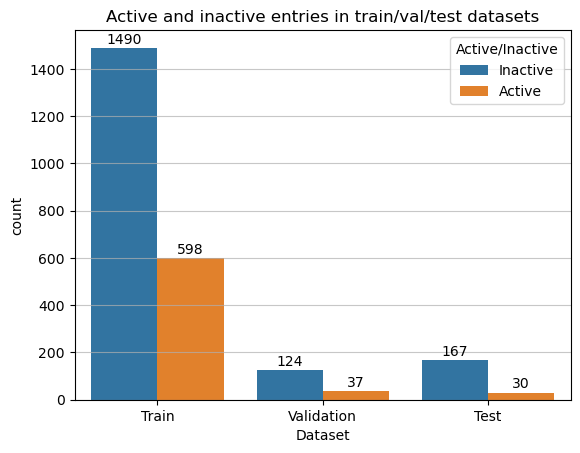

In [18]:
def plot_active_inactive(val_bin_df, train_bin_df, test_bin_df, descr='countplot_active_entries_train_val_test'):
    val_bin_df['Dataset'] = 'Validation'
    train_bin_df['Dataset'] = 'Train'
    test_bin_df['Dataset'] = 'Test'

    val_bin_df['active'] = val_bin_df['active'].astype(bool)
    train_bin_df['active'] = train_bin_df['active'].astype(bool)
    test_bin_df['active'] = test_bin_df['active'].astype(bool)

    tmp = pd.concat([train_bin_df, val_bin_df, test_bin_df], axis=0)
    tmp['Active/Inactive'] = tmp['active'].apply(lambda x: 'Active' if x else 'Inactive')

    top_n = tmp['Active/Inactive'].value_counts().index
    ax = sns.countplot(data=tmp, hue='Active/Inactive', x='Dataset', hue_order=['Inactive', 'Active'])

    for bars_group in ax.containers:
        ax.bar_label(bars_group, padding=1) # fontsize=12

    plt.grid(axis='y', alpha=0.7)
    plt.title('Active and inactive entries in train/val/test datasets')
    f = os.path.join(fig_dir, descr)
    plt.savefig(f + '.pdf', bbox_inches='tight')
    plt.savefig(f + '.png', bbox_inches='tight')
    plt.show()
    plt.close()
    del val_bin_df['Dataset']
    del train_bin_df['Dataset']
    del test_bin_df['Dataset']


val_bin_df = dataframes['val_bin'].copy()
train_bin_df = dataframes['train_bin'].copy()
test_bin_df = dataframes['test_bin'].copy()
plot_active_inactive(val_bin_df, train_bin_df, test_bin_df)
del val_bin_df
del train_bin_df
del test_bin_df

#### Upsampling/Downsampling

From this [blogpost](https://towardsdatascience.com/heres-what-i-ve-learnt-about-sklearn-resample-ab735ae1abc4).

TODO: While resampling, introducing variations to the data, for example by giving a different SMILES representation (for the same molecule ofc) for each new sample.

Original SMILES: COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)C2(F)CC2)C(C)(C)C)CC1
Original molecule:


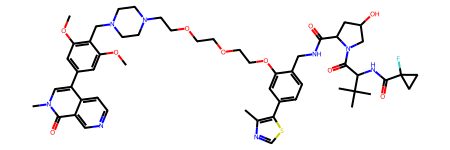

Transformed molecule:


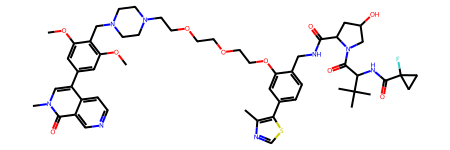

Transformed SMILES: C1N(CCOCCOCCOc2cc(-c3c(C)ncs3)ccc2CNC(=O)C2N(C(=O)C(C(C)(C)C)NC(C3(F)CC3)=O)CC(O)C2)CCN(Cc2c(OC)cc(-c3cn(C)c(=O)c4cnccc34)cc2OC)C1


In [19]:
def shuffle_smiles(smiles):
    rand_config = {
        'isomericSmiles': False, # random.choice([True, False]),
        'kekuleSmiles': random.choice([True, False]),
        # 'rootedAtAtom': (optional) if non-negative, this forces the SMILES to start at a particular atom. Defaults to -1.
        'canonical': random.choice([True, False]),
        'allBondsExplicit': random.choice([True, False]),
        'allHsExplicit': random.choice([True, False]),
    }
    mol = Chem.MolFromSmiles(smiles)
    return Chem.MolToSmiles(mol, **rand_config)

def scramble_smiles(smiles, plot_mol=False):
    # Convert SMILES string to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    new_mol = copy.deepcopy(mol)
    # Round 1: randomize order of double bonds
    Chem.Kekulize(new_mol)
    # Round 2: shuffle atom indices
    atom_indices = list(range(new_mol.GetNumAtoms()))
    random.shuffle(atom_indices)
    new_mol = Chem.RenumberAtoms(new_mol, atom_indices)
    # Round 3: randomize order of double bonds again
    Chem.Kekulize(new_mol)
    # Generate a new SMILES string from the new molecule object
    new_smiles = Chem.MolToSmiles(new_mol, isomericSmiles=False, canonical=False)
    # Check if the scrambled molecule is the same as the original one
    canon_new_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True)
    canon_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(new_smiles), canonical=True)
    if plot_mol:
        print('Original molecule:')
        display(mol)
        print('Transformed molecule:')
        display(new_mol)
    if canon_smiles != canon_new_smiles:
        print(f'original/scrambled:\n{smiles}\n{new_smiles}')
        if smiles != new_smiles:
            pass
            # display(mol)
            # display(new_mol)
        print('-' * 80)
        return smiles
    else:
        return new_smiles

examples = dataframes['train_bin'].at[0, 'Smiles_nostereo']
print(f'Original SMILES: {examples}')
print(f'Transformed SMILES: {scramble_smiles(examples, plot_mol=True)}')

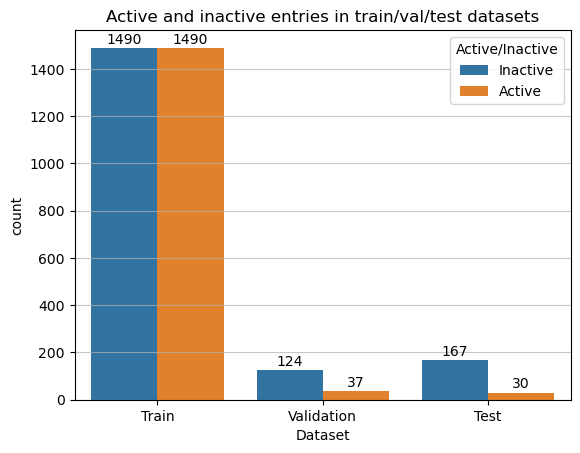

In [20]:
train_df = dataframes['train_bin']
active_df = train_df[train_df['active'] == True]
inactive_df = train_df[train_df['active'] == False]
# Set majority and minority classes datasets
if len(active_df) > len(inactive_df):
    majority_df = active_df
    minority_df = inactive_df
else:
    majority_df = inactive_df
    minority_df = active_df
# Upsample the minority class
n_samples = abs(len(active_df) - len(inactive_df))
minority_upsampled_df = resample(minority_df, random_state=42,
                                 n_samples=n_samples, replace=True)
# Transform SMILES strings of the upsampled class
minority_upsampled_df['Smiles_nostereo'] = minority_upsampled_df['Smiles_nostereo'].apply(scramble_smiles)
# Concatenate the upsampled dataframe
train_upsampled_bin_df = pd.concat([minority_upsampled_df, train_df], axis=0)
dataframes['train_bin_upsampled'] = train_upsampled_bin_df

val_bin_df = dataframes['val_bin'].copy()
test_bin_df = dataframes['test_bin'].copy()
plot_active_inactive(val_bin_df, train_upsampled_bin_df, test_bin_df)
del val_bin_df
del test_bin_df

In [21]:
conflict_idx = check_data_leakage(dataframes['train_bin'], dataframes['val_bin'])
assert len(conflict_idx) == 0, f'Found {len(conflict_idx)} conflicting entries between train and val sets!'
conflict_idx += check_data_leakage(dataframes['train_bin'], dataframes['test_bin'])
assert len(conflict_idx) == 0, f'Found {len(conflict_idx)} conflicting entries between train and test sets!'

No data leakage detected.
No data leakage detected.


## Add Columns for LLMs

In [22]:
# features = ["Smiles_nostereo", "poi_seq", "cell_type"] + ["e3_ligase_seq"] # + ["e3_ligase_seq"]
# features = ["Smiles_nostereo", "poi_seq", "e3_ligase_seq", "cell_type"]
features = ["Smiles_nostereo", "poi_seq", "e3_ligase", "cell_type"]
    
def get_text(row):
    text = ""
    for feature in features:
        if pd.notnull(row[feature]):
            text += f"{row[feature]}"
    return text

for k, df in dataframes.items():
    # df['text'] = df[['Smiles_nostereo', 'poi_seq', 'e3_ligase', 'cell_type']].values.tolist()
    df['text'] = df.apply(get_text, axis=1)
    df['label'] = df['active'].map({True: 'active', False: 'inactive'})

## Save Dataframes to File

In [23]:
# Save dataframse to csv files
for t in ['train', 'val', 'test']:
    for task in ['regr', 'bin']:
        key = f'{t}_{task}'
        df = dataframes[key]
        df.to_csv(os.path.join(data_dir, t, f'{key}.csv'), index=False)
filename = os.path.join(data_dir, 'train', f'train_bin_upsampled.csv')
dataframes['train_bin_upsampled'].to_csv(filename, index=False)

## Plotting Datasets

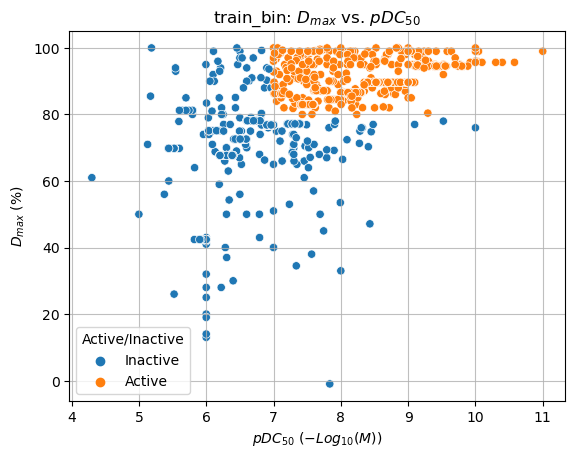

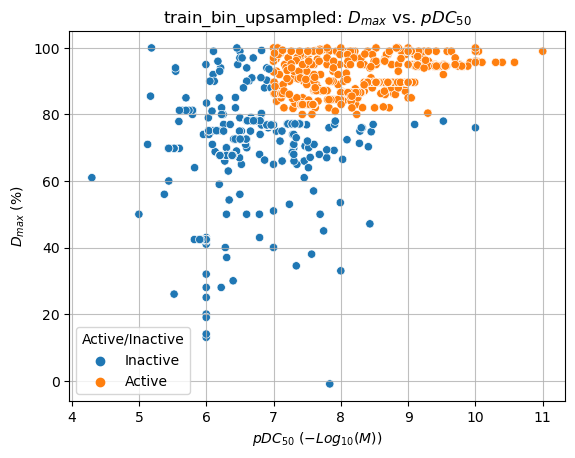

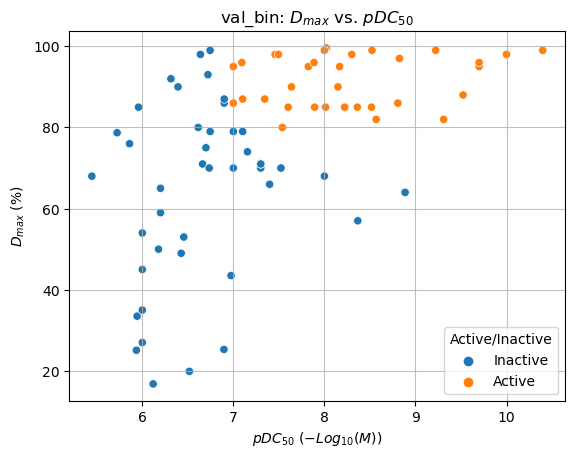

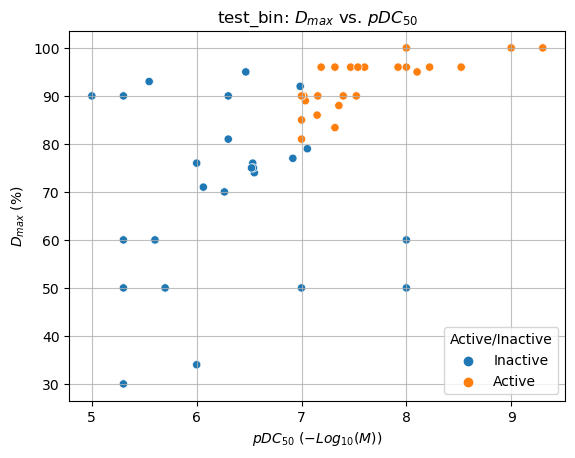

In [22]:
dfs = [
    (dataframes['train_bin'].copy(), 'train_bin'),
    (dataframes['train_bin_upsampled'].copy(), 'train_bin_upsampled'),
    (dataframes['val_bin'].copy(), 'val_bin'),
    (dataframes['test_bin'].copy(), 'test_bin'),
]
for tmp, df_name in dfs:
    tmp['pDC50'] = tmp['pDC50'].astype(float)
    tmp['Dmax'] = tmp['Dmax'].astype(float) * 100
    tmp['active'] = tmp['active'].replace({True: 'Active', False: 'Inactive'})
    if 'PROTAC-Pedia' in df_name:
        del tmp['Active/Inactive']
    old2new_names = {
        'pDC50': '$pDC_{50}$ ($-Log_{10}(M)$)',
        'Dmax': '$D_{max}$ (%)',
        'active': 'Active/Inactive',
    }
    tmp = tmp.rename(columns=old2new_names)

    sns.scatterplot(data=tmp, x='$pDC_{50}$ ($-Log_{10}(M)$)', y='$D_{max}$ (%)',
                    hue='Active/Inactive', hue_order=['Inactive', 'Active'])
    plt.grid(axis='both', alpha=0.8)
    plt.title(f'{df_name}' + ': $D_{max}$ vs. $pDC_{50}$')

    # f = os.path.join(fig_dir, f'scatter_{df_name.lower()}_active_entries')
    # plt.savefig(f + '.pdf', bbox_inches='tight')
    # plt.savefig(f + '.png', bbox_inches='tight')
    plt.show()
    plt.close()
del dfs

TODO:

* try different binning size
* try two-sided ANNOVA test in order to compare the distributions of the different bins. In this way, we might get some more information on how to split up the data
* try bswarm plot

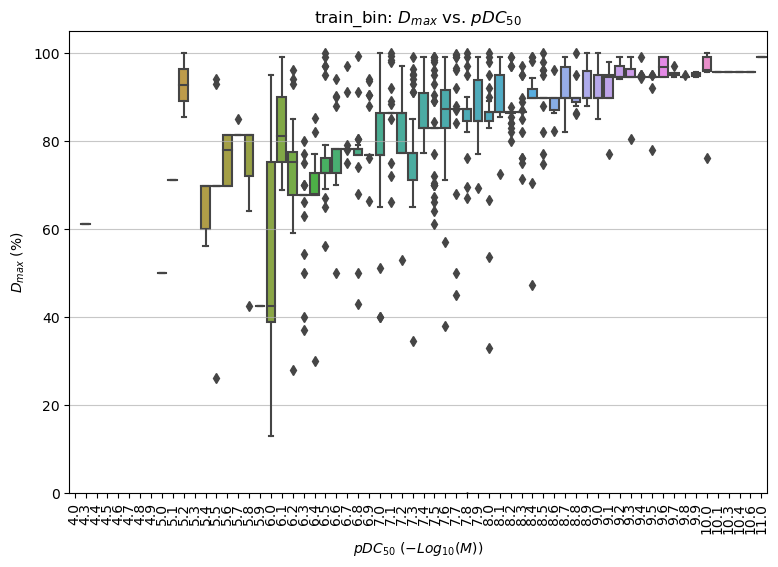

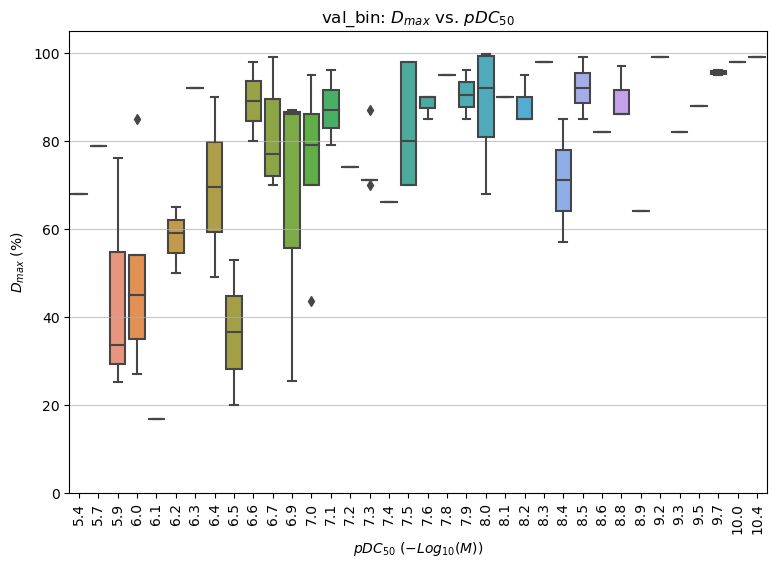

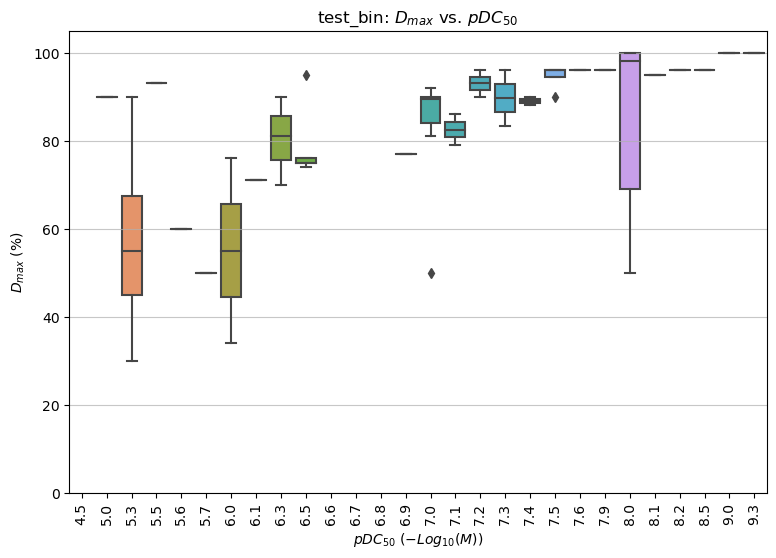

In [23]:
dfs = [
    (dataframes['train_bin'].copy(), 'train_bin'),
    (dataframes['val_bin'].copy(), 'val_bin'),
    (dataframes['test_bin'].copy(), 'test_bin'),
]
for tmp, df_name in dfs:
    tmp['pDC50'] = tmp['pDC50'].astype(float)
    tmp['Dmax'] = tmp['Dmax'].astype(float) * 100
    # Change the bin size by rounding
    tmp = (tmp[['pDC50', 'Dmax']]).round(1)
    old2new_names = {
        'pDC50': '$pDC_{50}$ ($-Log_{10}(M)$)',
        'Dmax': '$D_{max}$ (%)',
    }
    tmp = tmp.rename(columns=old2new_names)
    # Change plot/figure size
    plt.figure(figsize=(9, 6))
    ax = sns.boxplot(data=tmp, x='$pDC_{50}$ ($-Log_{10}(M)$)', y='$D_{max}$ (%)')
    plt.xticks(rotation=90)
    # plt.xlim(0.0, 50.0)
    plt.ylim(0., 105.)
    plt.grid(axis='y', alpha=0.7)
    plt.title(f'{df_name}' + ': $D_{max}$ vs. $pDC_{50}$')
    # f = os.path.join(fig_dir, f'boxplot_{df_name.lower()}_pDC50_vs_Dmax')
    # plt.savefig(f + '.pdf', bbox_inches='tight')
    # plt.savefig(f + '.png', bbox_inches='tight')
    plt.show()
    plt.close()
del dfs